### In this notebook we explore the data lightly and create some preliminary plots

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import collections
import os

processed_folder_path = os.path.join("..", "data", "processed")
unprocessed_folder_path = os.path.join("..", "data", "unprocessed")

## Plot data density

### NDSI and NDVI data density given time

In [2]:
df_NDSI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0, parse_dates=["date"])
df_NDVI = pd.read_csv(os.path.join(processed_folder_path, "NDSI.csv"), index_col=0, parse_dates=["date"])

df_NDSI = df_NDSI.loc[df_NDSI["date"].dt.year >= 1965]
df_NDVI = df_NDVI.loc[df_NDVI["date"].dt.year >= 1965]

In [3]:
def plot_data_density(dfs, labels):
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(df["date"].dt.year).size(), label=label)
    
    plt.title("Frequency of years in data")
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    for df, label in zip(dfs, labels):
        plt.plot(df.groupby(df["date"].dt.month).size(), label=label)

    plt.xticks(range(12), range(1, 13))
    plt.title("Frequency of months in data")
    plt.xlabel("Month")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

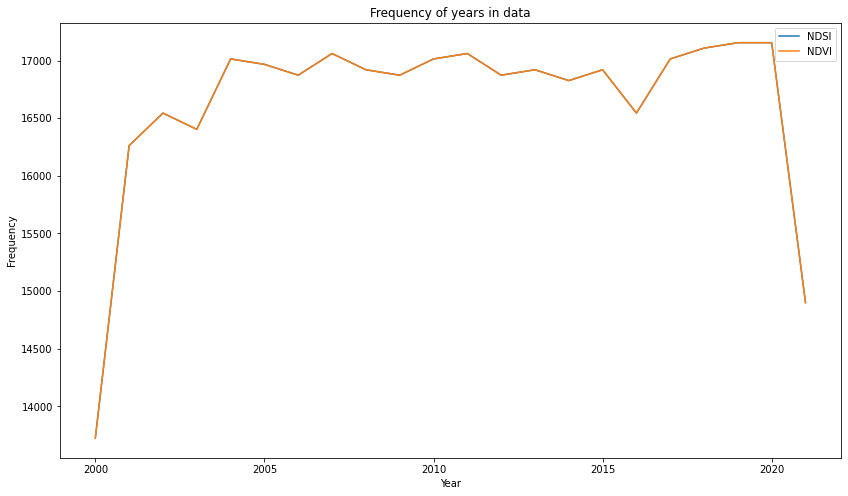

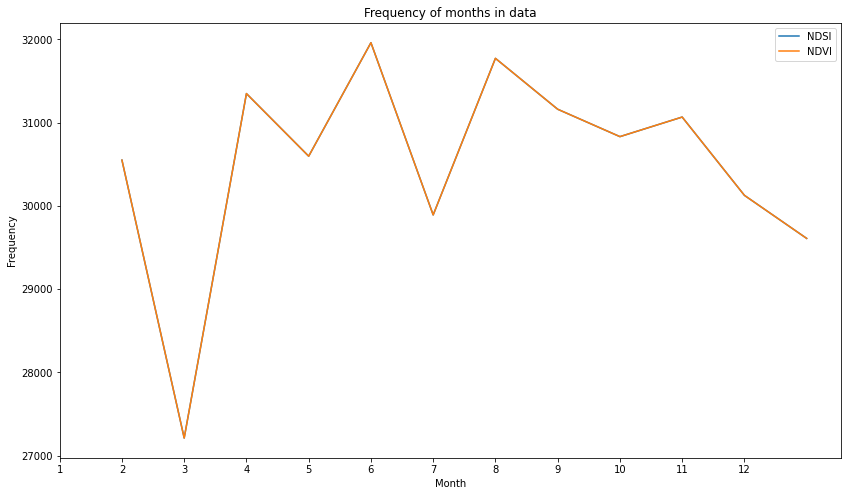

In [4]:
plot_data_density([df_NDSI, df_NDVI], ["NDSI", "NDVI"])

## River Flow Data
### Data Density

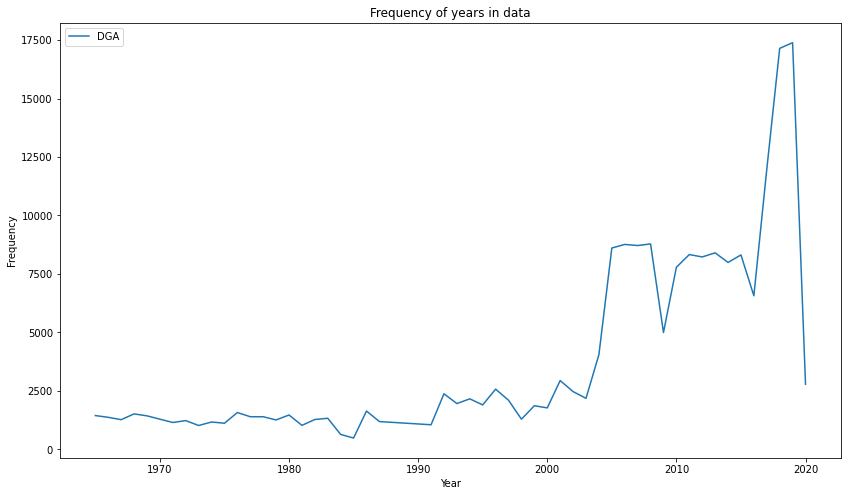

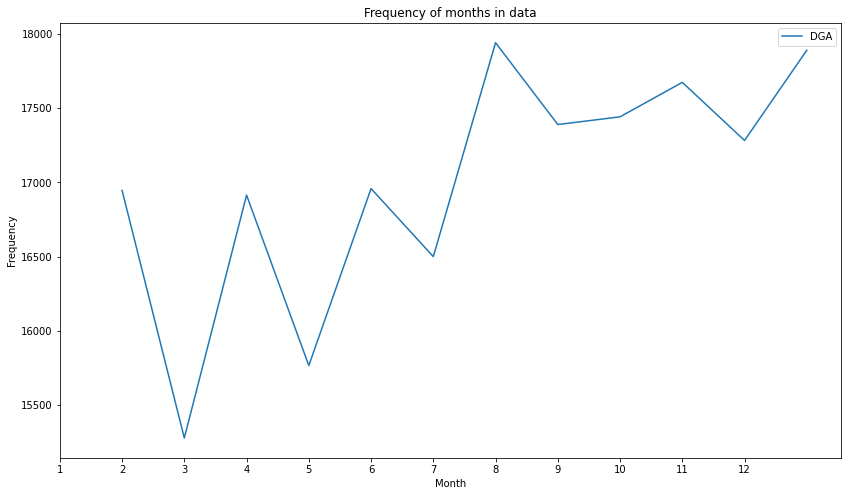

In [5]:
df_DGA = pd.read_csv(os.path.join(processed_folder_path, "DGA.csv"), index_col=0, parse_dates=["date"])
df_DGA = df_DGA.loc[df_DGA["date"].dt.year >= 1965]

plot_data_density([df_DGA], ["DGA"])

### Monthly Flow Data

We convert the data from a daily scale to a monthly scale by calculating the mean and the median per month.

In [46]:
monthly_flow_data_mean = df_DGA.groupby(pd.PeriodIndex(df_DGA['date'], freq="M"))['river_flow'].mean()
monthly_flow_data_median = df_DGA.groupby(pd.PeriodIndex(df_DGA['date'], freq="M"))['river_flow'].median()

print(monthly_flow_data_mean)
print(monthly_flow_data_median)

date
1965-01    1.046700
1965-02    1.000609
1965-03    1.210460
1965-04    1.612765
1965-05    1.582494
             ...   
2019-10    1.414894
2019-11    0.932803
2019-12    1.087817
2020-01    2.267644
2020-02    1.803165
Freq: M, Name: river_flow, Length: 595, dtype: float64
date
1965-01    1.0592
1965-02    1.0520
1965-03    1.2250
1965-04    1.6200
1965-05    1.6100
            ...  
2019-10    1.3832
2019-11    0.9200
2019-12    0.9200
2020-01    1.8520
2020-02    1.6380
Freq: M, Name: river_flow, Length: 595, dtype: float64


We add a flag denoting if a certain row is in the summer or winter.

Below we plot the yearly average measurements of all water years, distinguishing between the types of years (dry, normal or wet).

Average River Flow Measurements:
Dry Years:    1.572
Normal Years: 2.193
Wet Years:    2.003


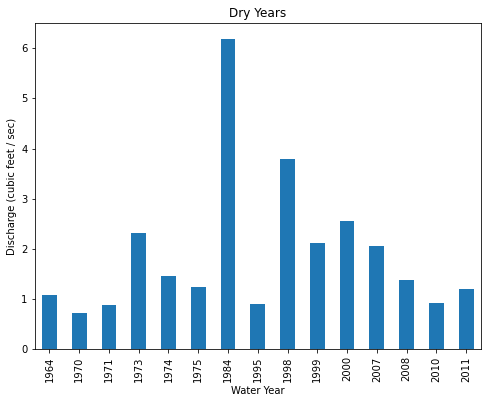

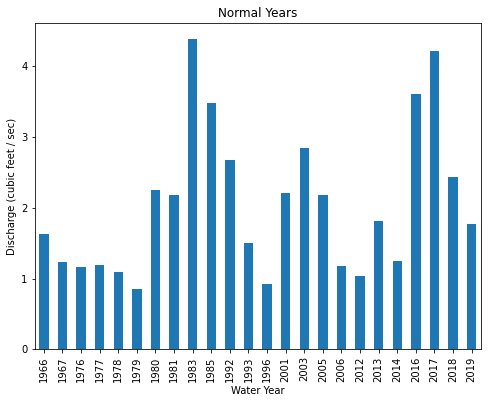

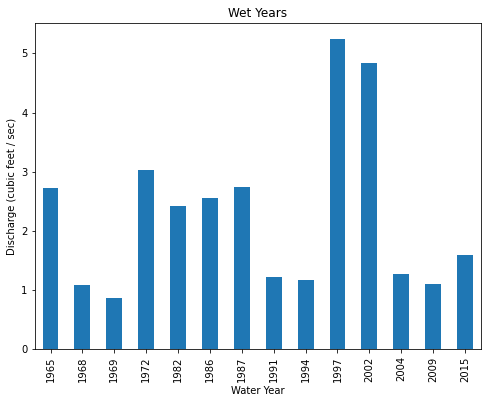

In [12]:
print("Average River Flow Measurements:")

print("Dry Years:   ", round(df_DGA.loc[df_DGA["year_type"] == -1]["river_flow"].mean(), 3))
print("Normal Years:", round(df_DGA.loc[df_DGA["year_type"] == 0]["river_flow"].mean(), 3))
print("Wet Years:   ", round(df_DGA.loc[df_DGA["year_type"] == 1]["river_flow"].mean(), 3))

dry_discharge_rate = df_DGA.loc[df_DGA["year_type"] == -1].groupby("water_year")[["river_flow"]].mean()
dry_discharge_rate.plot.bar(figsize=(8, 6), title="Dry Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)

normal_discharge_rate = df_DGA.loc[df_DGA["year_type"] == 0].groupby("water_year")[["river_flow"]].mean()
normal_discharge_rate.plot.bar(figsize=(8, 6), title="Normal Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)

wet_discharge_rate = df_DGA.loc[df_DGA["year_type"] == 1].groupby("water_year")[["river_flow"]].mean()
wet_discharge_rate.plot.bar(figsize=(8, 6), title="Wet Years", xlabel='Water Year', ylabel='Discharge (cubic feet / sec)', legend=False)

plt.show()